# Produisez une étude de marché

# Scénario
Votre entreprise **d'agroalimentaire** souhaite se développer à l'international. Elle est spécialisée dans...
 le poulet !

L'international, oui, mais pour l'instant, le champ des possibles est bien large : aucun pays particulier ni aucun continent n'est pour le moment choisi. Tous les pays sont envisageables !

Votre objectif sera d'aider **à cibler plus particulièrement certains pays**, dans le but d'approfondir ensuite l'étude de marché. Plus particulièrement, l'idéal serait de produire des "groupes" de pays, plus ou moins gros, dont on connaît les caractéristiques.

Dans un premier temps, la stratégie est plutôt d'exporter les produits plutôt que de produire sur place, c'est-à-dire dans le(s) nouveau(x) pays ciblé(s).


Pour identifier les pays propices à une insertion dans le marché du poulet,
 Il vous a été demandé de cibler les pays. 
 Etudier les régimes alimentaires de chaque pays, notamment en termes de protéines d'origine animale et en termes de calories.


Construisez votre échantillon contenant l'ensemble des pays disponibles, chacun caractérisé par ces variables :

différence de population entre une année antérieure (au choix) et l'année courante, exprimée en pourcentage ;
proportion de protéines d'origine animale par rapport à la quantité totale de protéines dans la disponibilité alimentaire du pays ;
disponibilité alimentaire en protéines par habitant ;
disponibilité alimentaire en calories par habitant.

Construisez un dendrogramme contenant l'ensemble des pays étudiés, puis coupez-le afin d'obtenir 5 groupes.

Caractérisez chacun de ces groupes selon les variables cités précédemment, et facultativement selon d'autres variables que vous jugerez pertinentes (ex : le PIB par habitant). Vous pouvez le faire en calculant la position des centroïdes de chacun des groupes, puis en les commentant et en les critiquant au vu de vos objectifs.

Donnez une courte liste de pays à cibler, en présentant leurs caractéristiques. Un découpage plus précis qu'en 5 groupes peut si besoin être effectué pour cibler un nombre raisonnable de pays. 

Visualisez vos  partitions dans le premier plan factoriel obtenu par ACP.

Dans votre partition, vous avez obtenu des groupes distincts. Vérifiez donc qu'ils diffèrent réellement. Pour cela, réalisez les tests statistiques suivants :

un test d'adéquation : parmi les 4 variables, ou parmi d'autres variables que vous trouverez pertinentes, trouvez une variable dont la loi est normale ;
un test de comparaison de deux populations (dans le cas gaussien) : choisissez 2 clusters parmi ceux que vous aurez déterminé. Sur ces 2 clusters, testez la variable gaussienne grâce à un test de comparaison.

In [ ]:
# Librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import sklearn as sk
import scipy as sp
import pca as pca
from sklearn import cluster
from sklearn.cluster import KMeans



In [ ]:
#Versions utilisées
print("Jupyter Notebook : " + str(pd.__version__))
print("Pandas : " + str(pd.__version__))
print("Numpy : " + str(np.__version__))
print("Seaborn : " + str(sns.__version__))

In [ ]:
sns.set( # Styles Seaborn
    style='whitegrid',
    context='notebook',
    palette='Paired',
    rc={'figure.figsize':(8,5)})

In [ ]:
# Couleurs
red_a400 = '#ff1744'
indigo_a100 = '#8c9eff'
indigo_a400 = '#3d5afe'
indigo_a700 = '#304ffe'
bluegrey_900 = '#263238'
teal_a400 = '#1de9b6'
purple_a400 = '#d500f9'
yellow_a400 = '#ffea00'
bluegrey_900 = '#263238'
palette_5 = [teal_a400, indigo_a400, red_a400, yellow_a400, purple_a400]

# Mission 1:  Construisez l'échantillon contenant l'ensemble des pays disponibles.
chacun caractérisé par ces variables :

différence de population entre une année antérieure (au choix) et l'année courante, exprimée en pourcentage ;
proportion de protéines d'origine animale par rapport à la quantité totale de protéines dans la disponibilité alimentaire du pays ;
disponibilité alimentaire en protéines par habitant ;
disponibilité alimentaire en calories par habitant.

## 1. La population par pays
la variation de la population entre 2009 et 2019, en %, qui sera positive en cas de croissance ou négative en cas de baisse démographique ;

Sources FAO (https://www.fao.org/faostat/fr/#data/OA)

In [ ]:
df_population = pd.read_csv('datas/fao-populations_2019- 2009.csv' , header=0, sep=",", decimal=".")
df_population.head(2)

In [ ]:
df_population = df_population[['Code zone (FAO)', 'Zone', 'Produit', 'Année', 'Valeur']]
df_population['Valeur'] = df_population['Valeur']*1000
df_population.head()

In [ ]:
#pivot
df_population = df_population.pivot_table(index=['Code zone (FAO)','Zone'], columns='Année', values = 'Valeur', aggfunc = sum).reset_index()
df_population



In [ ]:
#rename
df_population.columns = ['Code zone (FAO)','Zone', '2009', '2019']

#variable creation
df_population['Évolution population (%)'] = round((df_population['2019'] - df_population['2009']) /
                                               df_population['2019'] *100,2)


population2009 = df_population['2009'].sum()
population2019 = df_population['2019'].sum()
evolution_globale = round(((population2019 - population2009) / population2009)*100,3)
print('Pour indication, la population totale en 2009 était de', population2009, 'et de', population2019, 'en 2019.\nL\'évolution 2009/2019 est de', evolution_globale, '%.')


df_population= df_population.rename(columns= {'2019': 'population',})
df_population= df_population[[ 'Code zone (FAO)','Zone'  ,'population' ,'Évolution population (%)']]

#show

df_population

In [ ]:
df_population.shape

## 2. Données sur les bilans alimentaires mondiaux (2019)



Sources FAO (http://www.fao.org/faostat/fr/#data)


In [ ]:
df_dispo_alimentaire = pd.read_csv('datas/les bilans alimentaires 2019.csv', header=0, sep=",", decimal=".")
df_dispo_alimentaire.head(4)

In [ ]:
df_dispo_alimentaire = df_dispo_alimentaire.pivot_table(index=[ 'Zone','Code zone (FAO)'],
                                columns=['?l?ment', 'Produit'],
                                values = 'Valeur',
                                aggfunc=sum).reset_index()
df_dispo_alimentaire.head()

In [ ]:
df_dispo_alimentaire["ratio_proteines_animales(%)"] = round((df_dispo_alimentaire[('Disponibilit? de prot?ines en quantit? (g/personne/jour)', 'Produits Animaux')]
                                                                         /df_dispo_alimentaire[('Disponibilit? de prot?ines en quantit? (g/personne/jour)', 'Total General')])*100,2)
df_dispo_alimentaire.head(2)

In [ ]:
df= pd.merge(df_population, df_dispo_alimentaire, on="Code zone (FAO)")

df.head()

In [ ]:
df = df[['Code zone (FAO)','Zone', 'population','Évolution population (%)',
         ('Disponibilit? alimentaire (Kcal/personne/jour)', 'Total General'),
         ('Disponibilit? de prot?ines en quantit? (g/personne/jour)', 'Total General'),
         ('ratio_proteines_animales(%)','') ]]
df.head()

In [ ]:
df.rename(columns={('Disponibilit? alimentaire (Kcal/personne/jour)', 'Total General'):'dispo_calories',
                              ('Disponibilit? de prot?ines en quantit? (g/personne/jour)', 'Total General'):'dispo_proteines',
                            ('ratio_proteines_animales(%)','' ):'ratio_proteines_animales(%)'}
                     ,inplace=True)

df['dispo_calories'] = df['dispo_calories']*365
df['dispo_proteines'] = df['dispo_proteines']*365
df.head()

## 3.  Les valeurs de PIB par habitant,
https://www.fao.org/faostat/fr/#data/FS

In [ ]:
# Dataframes des données complémentaires
# Indicateurs Macro (PIB et croissance)
df_PIB_habitant = pd.read_csv('datas/PIB.csv', header=0, sep=',', decimal='.')

df_PIB_habitant

In [ ]:
df_PIB_habitant = df_PIB_habitant[['Code zone (FAO)','Élément','Valeur','Produit']]
                        
df_PIB_habitant

In [ ]:
df_PIB_habitant = df_PIB_habitant.pivot_table(index=['Code zone (FAO)'], columns='Élément', values='Valeur', aggfunc=sum).reset_index()
df_PIB_habitant

In [ ]:

df_PIB_habitant = df_PIB_habitant.rename(columns={'Valeur US $ par habitant':"PIB_par_habitant",'Valeur US $':'PIB(M)' })
df_PIB_habitant     

## 4. Production viande de Volailles, taux d'autosuffisance
défini en économie comme le rapport entre les importations et la disponibilité intérieure du pays ;

https://www.fao.org/faostat/fr/#data/FBS

In [ ]:
df_viande_volailles = pd.read_csv('datas/la viande de volailles1!.csv', header=0, sep=",", decimal=".")
df_viande_volailles.head(6)

In [ ]:
df_viande_volailles = df_viande_volailles.pivot_table(index=['Code zone (FAO)'],
                                columns=['Élément'],
                                values = 'Valeur',
                                aggfunc=sum).reset_index()
#Le taux_suffisance= Production  ÷ (Production alimentaire domestique + importations ー exportations) ×100
df_viande_volailles['taux_suffisance(٪)']=((df_viande_volailles['Production'] ) / 
                                           (df_viande_volailles['Disponibilité intérieure']))*100



#le taux de dépendance aux importations, défini en économie comme le rapport entre les importations et la disponibilité intérieure du pays ;

df_viande_volailles['taux_dépendance_importations(٪)']=(df_viande_volailles['Importations - Quantité'] /
                                                        df_viande_volailles['Disponibilité intérieure'])*100



#df_viande_volailles['taux_Exportations(%)']=(df_viande_volailles['Exportations - Quantité'] /
                                                        #df_viande_volailles['Disponibilité intérieure'])*100

df_viande_volailles = df_viande_volailles[['Code zone (FAO)','taux_suffisance(٪)','taux_dépendance_importations(٪)']]

df_viande_volailles

**Le taux d'auto-suffisance alimentaire** est un indice permettant de mesurer l'importance de la production alimentaire d'un pays par rapport à sa consommation intérieure.




# Dataframe principal

In [ ]:

df= pd.merge(df, df_PIB_habitant, on="Code zone (FAO)")



df= pd.merge(df, df_viande_volailles, on="Code zone (FAO)")
df.head()

In [ ]:
df.info()

In [ ]:
#Identifier la présence de doublons
print(df.duplicated().sum())


In [ ]:
#Trouver les valeurs manquantes
df_null=  df.loc[df.isnull().any(axis=1)]
df_null

In [ ]:
df=df.dropna()


In [ ]:
df.describe()

In [ ]:
#Retrait du pays 'France' sur notre échantillon 
df = df[df['Zone'] != 'France']

In [ ]:
#Calcul de fréquence en Chine
df[df['Zone'].str.contains('hin')]

In [ ]:
#Supprimer la ligne Chine
df = df[df['Zone'] != 'Chine']



In [ ]:
#Vérification d'éventuelles valeurs manquantes et/ou en doubles dans l'échantillon
print(df.duplicated().sum())
print(df.isna().sum())

In [ ]:
df= df.rename(columns={'Zone': 'pays'} )

In [ ]:
df.style.background_gradient(cmap='BrBG')


In [ ]:
df

In [ ]:
df.to_csv('exports/df.csv', index=False)

In [ ]:
df = df[df['pays'] != 'Pays-Bas']

# Mission 2 : réalisation d'un dendrogramme

Construisez un dendrogramme contenant l'ensemble des pays étudiés, puis coupez-le afin d'obtenir 5 groupes.

Caractérisez chacun de ces groupes selon les variables cités précédemment, et facultativement selon d'autres variables que vous jugerez pertinentes (ex : le PIB par habitant). Vous pouvez le faire en calculant la position des centroïdes de chacun des groupes, puis en les commentant et en les critiquant au vu de vos objectifs.

Donnez une courte liste de pays à cibler, en présentant leurs caractéristiques. Un découpage plus précis qu'en 5 groupes peut si besoin être effectué pour cibler un nombre raisonnable de pays. 


# Environnement


In [ ]:
#pays comme index
df_clus=df.set_index('pays', drop=True, append=False, inplace=False, verify_integrity=False)

# préparation des données pour le clustering
df_clus = df_clus[["Évolution population (%)", "dispo_calories",
                                 "dispo_proteines",'ratio_proteines_animales(%)',
                                 'PIB_par_habitant','taux_suffisance(٪)','taux_dépendance_importations(٪)']]

df_clus.head(2)


# Aperçu des corrélations

In [ ]:
plt.figure(figsize=(15,5))

mask = np.zeros_like(df_clus.corr())
mask[np.triu_indices_from(mask)] = True

sns.heatmap(df_clus.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')

plt.xticks(rotation=25, ha='right')
plt.title('La corrélation des variables',  fontsize=18, pad=20)

plt.show()

# Observations

D'après le tableau de corrélation coloré ci-dessus, on peut constater une corrélation positive  forte entre la disponibilité alimentaire en protéine par personnes et celle en kcal par personne et la pourcentage de protéine d'origine animale et le PIB .


Dans une moindre mesure, on retrouve également une corrélation négative entre le pourcentage d'évolution de la population et les différents régimes alimentaires des pays (protéines, kcal, pourcentage de protéine d'origine animale).

**Nous sommes intéressés par les pays les plus susceptibles de consommer du poulet, donc ceux ayant un fort ratio de protéines animales. Les corrélations montrent que ces pays sont susceptibles d'avoir un fort PIB, et de grandes disponibilités en protéines et calories.**

# Clustering

## Classification des pays via Clustering Hiérarchique Ascendant (CHA)

La classification sera établie sur la base des variables suivantes :

**La différence de population entre l'année 2013 et l'année 2019, exprimée en pourcentage;\
La proportion de protéines d'origine animale par rapport à la quantité totale de protéines dans la disponibilité alimentaire du pays;\
La disponibilité alimentaire en grammes de protéines par habitant ;\
La disponibilité alimentaire en Kcal par habitant.\
PIB par habitant.\
Rapport de dépendance à l'importation.\
La taux suffisance(٪).**

L'échantillon comporte peu de variables sur la dimension dite du "Régime alimentaire" et et variables économiques, il comporte également un nombre de pays "maîtrisables" qui permet de commencer par une classification hiérarchique. Algorithme qui a une forte complexité algorithmique en temps et en espace, le clustering hiérarchique est recommandé pour les petits échantillons.



Le clustering permet de regrouper des individus similaires, c'est-à-dire qu'il va partitionner l'ensemble des individus. On cherche donc à ce que les groupes soient :

    **Resserrés sur eux-mêmes : deux points qui sont proches devraient appartenir au même groupe.
  
    **Loin les uns des autres, c’est-à-dire qu’ils soient fortement différenciés.

Au préalable, il est nécessaire de centrer-réduire les données. C’est à dire, recalculer chaque valeur de manière à ce que la moyenne de la variable soit égale à 0 et la variance et l’écart-type égalent 1. Pour une variable donnée, on soustrait à chaque valeur la moyenne de la variable, puis on divise le tout par l’écart-type.

Ensuite, nous pouvons procéder à la classification ascendante hiérarchique selon la méthode de Ward. 


In [ ]:

from sklearn import preprocessing
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram


# dans array numpy
X = df_clus.values 
#nous allons extraire les données d'expression de 172 pays  dans un tableau de données numériques .
 #X comporte uniquement les données  , il ne contient pas les étiquettes des échantillons.

pays = df_clus.index
 #Conservons les étiquettes de chaque échantillon  dans la variable pays.




#centering and reduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

#Standardisez les caractéristiques en supprimant la moyenne et en mettant à l'échelle la variance unitaire.
#Le score standard d'un échantillon x est calculé comme suit :
#z = (x - u) / s où
# u est la moyenne des échantillons d'apprentissage ou zéro si with_mean=False, 
# s est l'écart type des échantillons d'apprentissage ou un si with_std=False.

#X_cr =array([[-0.90652015,  0.30068128,  0.61600031, ..., -0.47817227,
        #-1.15900796,  0.84483273],
       #[ 1.29355645, -1.35075836, -1.15709131, ..., -0.68784567,
        #-0.7198978 ,  0.54941119],...,

        
#X_cr = pd.DataFrame(X_cr, index =pays, columns=df_clus.columns)

# Clustering hiérarchique avec librairie scipy
z=linkage(X_scaled, method='ward' ,metric='euclidean')

# Affichage du dendogramme
plt.figure(figsize=(12,25), dpi=300)
plt.title('Dendogramme de classification ascendante hiérarchique (CAH)')
plt.xlabel('distance')
dendrogram(
    z,#Regroupement hiérarchique encodé avec la matrice renvoyée par la fonction de linkage.
    labels = pays,
    orientation = "right",
    color_threshold=7
)
plt.savefig('exports/dendogram_CAH_1.png')
plt.show()

Une fois le dendrogramme obtenu, nous pouvons choisir en combien de clusters nous pouvons diviser notre arbre. Ici, une partition en 5 clusters permet d’avoir des groupes de taille raisonnable à analyser.

Graphiquement, on voit bien que la méthode de Ward a permis de minimiser les distances intra-classes à chaque regroupement.


Essayons de caractériser chacun de ces clusters en regardant la valeur de leurs centroïde pour chaque variable. Les centroïdes représentent tout simplement la valeur moyenne d’une variable pour un cluster donné.
Différences entre les clusters :

In [ ]:
plt.figure(figsize=(12,8), dpi=300)
plt.title('Dendogramme de classification ascendante hiérarchique tronqué')
plt.xlabel('distance')
plt.grid(False)
dendrogram(
    z,      #linkage(X_cr, method='ward' ,metric='euclidean'),
    truncate_mode='lastp', #Les p derniers clusters non singleton formés dans la liaison sont les seuls nœuds non feuilles dans la liaison ; 
    p = 5,
    labels = pays,
    orientation = "right",
    show_contracted=True,)
plt.savefig('exports/dendogram_CAH_truncated_1.png')
plt.show()



# Attribution des 5 groupes et World map de répartition

In [ ]:
# Coupage du dendrogramme en 5 clusters avec Scipy
groupe_cah = fcluster(z, 5, criterion='maxclust')
#array([2, 1, 4, 5, 2, 2, 5, 3, 3, 2, 4,....
#pas plus de t clusters  sont formées.
#fcluster: formez des clusters plats à partir du clustering hiérarchique défini par la matrice de liaison donnée.

#affichage des pays et leurs groupes
df_groupage_1 = pd.DataFrame(columns=["groupe_cah","pays"])
df_groupage_1["pays"] = df_clus.index
df_groupage_1["groupe_cah"] = groupe_cah

df_groupage_1

In [ ]:
groupe_cah

In [ ]:
# Jointure pour ajout des groupes dans le dataframe principal
df_groupes_cah = pd.merge(df_clus, df_groupage_1, on="pays")
df_groupes_cah.to_csv('exports/groupes_cah.csv', index=False)
df_groupes_cah.sample(5)

# Centroïdes des clusters

In [ ]:
#Première comparaison des moyennes afin d'identifier le groupe de pays le plus porteur à ce niveau de l'analyse
df_groupes_cah.groupby('groupe_cah').mean()

In [ ]:
#Préparation de sous-ensembles permettant de caractériser les groupes un à un
df_groupe1_cah = df_groupes_cah[df_groupes_cah['groupe_cah'] == 1]
df_groupe2_cah = df_groupes_cah[df_groupes_cah['groupe_cah'] == 2]
df_groupe3_cah = df_groupes_cah[df_groupes_cah['groupe_cah'] == 3]
df_groupe4_cah = df_groupes_cah[df_groupes_cah['groupe_cah'] == 4]
df_groupe5_cah = df_groupes_cah[df_groupes_cah['groupe_cah'] == 5]



In [ ]:


#Pays du groupe 1 et 2 identifiés comme potentiellement intéressants

print('groupe 1')
print('----------')
print(df_groupe1_cah['pays'].unique())
print('------------------------------------------------------------')
print('------------------------------------------------------------')


print('groupe 2')
print('----------')
print(df_groupe2_cah['pays'].unique())
print('------------------------------------------------------------')
print('------------------------------------------------------------')


print('groupe 3')
print('----------')
print(df_groupe3_cah['pays'].unique())
print('------------------------------------------------------------')
print('------------------------------------------------------------')


print('groupe 4')
print('----------')
print(df_groupe4_cah['pays'].unique())
print('------------------------------------------------------------')
print('------------------------------------------------------------')


print('groupe 5')
print('----------')
print(df_groupe5_cah['pays'].unique())
print('------------------------------------------------------------')
print('------------------------------------------------------------')






In [ ]:
#Comparaison visuelle des groupes par Boxplot, en abscisse les numéros des groupes
plt.figure(figsize=(20, 20))
sns.set(style="whitegrid")

plt.subplot(221)
sns.boxplot(data=df_groupes_cah, x='groupe_cah', y='dispo_calories')

plt.subplot(222)
sns.boxplot(data=df_groupes_cah, x='groupe_cah', y='dispo_proteines')

plt.subplot(223)
sns.boxplot(data=df_groupes_cah, x='groupe_cah', y='ratio_proteines_animales(%)')

plt.subplot(224)
sns.boxplot(data=df_groupes_cah, x='groupe_cah', y='Évolution population (%)')

plt.savefig("exports/boxplot_dendogramme3.png")




plt.show(block=False)

# Description et critique des clusters

In [ ]:


#Comparaison visuelle des groupes par Boxplot, en abscisse les numéros des groupes
plt.figure(figsize=(20, 20))
sns.set(style="whitegrid")

plt.subplot(221)
sns.boxplot(data=df_groupes_cah, x='groupe_cah', y='dispo_calories')


plt.subplot(222)
sns.boxplot(data=df_groupes_cah, x='groupe_cah', y='dispo_proteines')

plt.subplot(223)
sns.boxplot(data=df_groupes_cah, x='groupe_cah', y='ratio_proteines_animales(%)')

plt.subplot(224)
sns.boxplot(data=df_groupes_cah, x='groupe_cah', y='Évolution population (%)')


plt.savefig("exports/boxplot_dendogramme3.png")




plt.show(block=False)

In [ ]:
#Comparaison visuelle des groupes par Boxplot, en abscisse les numéros des groupes
plt.figure(figsize=(20, 20))
sns.set(style="whitegrid")

plt.subplot(221)
sns.boxplot(data=df_groupes_cah, x='groupe_cah', y='PIB_par_habitant')


plt.subplot(222)
sns.boxplot(data=df_groupes_cah, x='groupe_cah', y='taux_dépendance_importations(٪)')


plt.subplot(223)
sns.boxplot(data=df_groupes_cah, x='groupe_cah', y='taux_suffisance(٪)')


plt.savefig("exports/boxplot_dendogramme3.png")




plt.show(block=False)

Le clusters 1, situés majoritairement en Afrique, sont ceux qui ont les démographies les plus fortes et les PIB/habitants les plus faibles.

Le cluster 3  reflète au contraire des pays en moyenne plus riches comme les USA ou la plupart des pays européens.

Le cluster 2,4 et 5 est dans une position intermédiaire et regroupe principalement des pays émergeants tels que l'Inde.




Quant aux disponibilités alimentaires, elles suivent les mêmes tendances que le PIB. Les pays les plus pauvres ont moins accès à la nourriture. Cela fait écho au problème de dénutrition mis en évidence lors du projet 3.

La consommation de protéines animales confirme le cloisonnement, avec une forte alimentation carnée de la part des clusters 3 et 4.

Les deux dernières variantes se développent complètement différemment. On voit que les groupes 2   et 4 sont  ceux qui importent beaucoup plus de viande de volaille qu'ils n'en produisent.

En fait, ce sont eux qui détiennent les taux d'autosuffisance les plus bas. Au contraire, le Groupe   5 est majoritairement autosuffisant et importe peu par rapport à sa production.

Les groupes qui dépendent fortement des importations sont les meilleures cibles pour nos ventes.
En plus des groupes qui ont le PIB le plus élevé.
Nous choisirons donc le groupe 2 et le groupe 3
Ces pays consomment en moyenne plus de protéines d'origine animale que le reste des groupes ;

In [ ]:
df_select_pays_cah = df_groupes_cah[df_groupes_cah["groupe_cah"].isin([2,3]) == True]

df_select_pays_cah.to_csv('exports/df_select_pays_cah.csv', index=False)
df_select_pays_cah.shape
df_select_pays_cah

In [ ]:
df_select_pays_cah.shape

En conclusion pour cette première division,62 pays deviendraient vraisemblablement une cible appropriée pour l'entreprise. La demande sera présente dans ces pays.
Appliquons une autre méthode, celle des K-Means, afin de pouvoir comparer cette première sélection.

# Application de l'algorithme du K-Means


Le clustering K-Means est une méthode de clustering simple mais puissante qui crée 𝑘 segments distincts des données où la variation au sein des clusters est aussi petite que possible. Pour trouver le nombre optimal de clusters, je vais essayer différentes valeurs de 𝑘 et calculer l'inertie, ou score de distorsion, pour chaque modèle.
 L'inertie mesure la similarité du cluster en calculant la distance totale entre les points de données et leur centre de cluster le plus proche. Les clusters avec des observations similaires ont tendance à avoir des distances plus petites entre eux et un score de distorsion plus faible dans l'ensemble.

## La méthode de coude nous aidera pour identifier les clusters.


•Nous choisissons 'K' manuellement, par visualisation.

• Calculer les distances entre les points d'un cluster (With-in Cluster Sum of Squares "WCSS").

• Si nous minimisons 'WCSS', nous avons atteint la solution de clustering parfaite.


In [ ]:
from sklearn.cluster import KMeans
from sklearn import cluster


K=range(1,10)
k_means = []
#On fait une boucle de 2 à 9 pour tester toutes ces possibiliéts
for k in K:
    #pour chaque k, on crée un modèle et on l’ajuste
    km=KMeans(n_clusters=k,init="k-means++").fit(X_scaled)
     #on stocke l’inertie associée
    k_means.append(km.inertia_)


#Visualisation des valeurs d'inertie pour chaque nombre de cluster
plt.plot(range(1, 10), k_means, marker='o')
plt.show()

In [ ]:
mycenters = pd.DataFrame({'groupe_km' : K, 'WSS' : k_means})
mycenters

Idéalement, pour optimiser et ne pas perdre trop d'informations, il est conseillé de choisir k = 5 .
 Un clustering  en 5 permettra de de comparer le partitionnement avec les groupes de la classification hiérarchique. Il est pertinent de comparer les deux méthodes sur le même nombre de clusters.



In [ ]:

#Clustering K-Means en 5 clusters
km = cluster.KMeans(n_clusters=5)
km.fit(X_scaled)
#Récupération des clusters attribués à chaque individu (classes d'appartenance)
clusters_km = km.labels_
clusters_km



On obtient donc un tableau de 5 lignes et 7 colonnes, pourquoi ?
Nous avons cinq groupes et sept variables.
**Pour réduire les dimensions, nous avons besoin de pca**

# Visualisation des clusters en ACP pour la projection des données


Le principe de **la réduction de dimension** est de réduire la complexité superflue d'un dataset en projetant ses données dans un espace de plus petite dimension .

Le principe  de **ACP** est de projeter nos données sur des axes appelés Composantes Principales, en cherchant à minimiser la distance entre nos points et leur projections. De cette manière on réduit la dimension préservant au maximum la variance de nos données. Pour **Préserver un maximum de variance pour optenir la projection qu'il soit la plus fidèle possible à nos données.**
 
 Analyse Pour trouver les axes de projection (xp): 
 Pour faire ça dans point de vue mathématique on
 1. On calcule la matrice de covariance des données 
 2. On détermine les vecteurs propres de cette matrice : ce sont les Composantes Principales 
 3. (On projette les données sur ces axes)
 


 
**L'ACP (Analyse en Composante Principale) permettra une visualisation des clusters pays sur le premier plan factoriel (ou plus). Il deviendra alors facile de pouvoir appréhender le "comportement" des différents groupes.**

PCA est un transformer ! 
1. Définir le nombre de composantes 
2. Transformer les données avec fit transform()

Il y a deux cas possibles pour choisir le nombre de composantes sur lesquels projeter nos données? et bien :
1. Celui dans lequel vous cherchez à visualiser vos données dans un espace de 2d ou 3D ,pour ça c'est très simple, le nombre de composants doit être égale à deux ou trois
2. Celui dans lequel vous cherchez à compresser vos données pour accélérer l'apprentissage de la machine sur des taches de classification ou de régression, pour ça il faut choisir le nombre de composantes de telle sorte à préserver entre 95 et 99 % de la variance de vos données.


L’enjeu d’une ACP est de trouver le meilleur plan de projection ayant la plus grande inertie, c’est à dire limitant le plus la perte d’information originelle. Les 7 variables seront synthétisées en de nouvelles variables : PC1, PC2, etc...

Comme précédemment, une ACP ne peut se faire que si les données sont centrées et réduites (transformation pour que moyenne = 0, écart-type = 1).

### Définir le nombre de composantes 

In [ ]:
import pca as pca
from sklearn import decomposition

# Affichage du clustering par projection des individus sur les 2 plans factoriels.
pca = decomposition.PCA().fit(X_scaled) #sklearn
X_projected = pca.transform(X_scaled)


#nous allons examiner quel est le pourcentage de variance préserver pour chacune de nos composantes.
scree = pca.explained_variance_ratio_*100
plt.bar(np.arange(len(scree))+1, scree)
plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')   
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.show()

#Pourcentage de variance expliquée par les composantes principales à l'aide de .explained_variance_ratio_
print(scree.cumsum())





Environ 75 % de la variance des données s'explique par ces deux premières composantes.
La méthode du coude précise une forte représentation de nos variables sur les deux premières composantes principales, le premier axe factoriel.


# ACP - Cercle des corrélations

In [89]:
def cerle_corr(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks:
        if d2 < n_comp:

            # initialisation de la figure
            #fig, ax = plt.subplots(figsize=(12,(n_comp*2)))
            #ax.set_aspect('equal', adjustable='box')
            fig=plt.figure(figsize=(12,12))
            fig.subplots_adjust(left=0.1,right=0.9,bottom=0.1,top=0.9)
            ax=fig.add_subplot(111)
            ax.set_aspect('equal', adjustable='box')

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            else :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
        
            # affichage des flèches
            plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

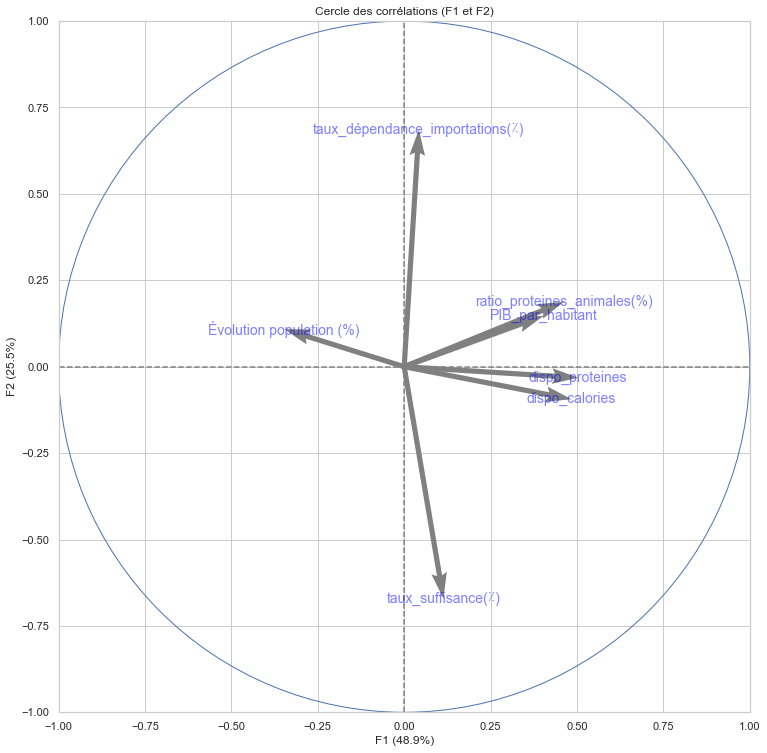

In [90]:
pcs = pca.components_
cerle_corr(pcs, 4, pca, [(0,1)], labels = np.array(df_clus.columns))

Ici, l’axe F2 reflète bien le taux de dépendance aux importations et le taux d’autosuffisance. Plus la valeur de l’axe 2 est positive, et plus le pays est importateur. Au contraire, plus les valeurs sont négatives, et plus le pays est autosuffisant avec sa production de viande de volailles et importe peu.



On peut d'ailleurs calculer les valeurs de ces variables synthétiques F1 et F2 qui pourraient remplacer les autres variables :



In [91]:
X_projected

array([[ 0.8703233 ,  1.29893423, -1.14895213, ..., -0.40850049,
         0.04941699,  0.07348783],
       [-2.73129301,  0.77475337,  0.44481159, ...,  0.32744129,
        -0.2008884 ,  0.26500877],
       [ 1.88625313,  0.70439536, -1.26686964, ..., -0.30137802,
        -0.28606647,  0.44216986],
       ...,
       [ 3.54672586,  2.91263378,  3.23247528, ...,  0.15575389,
        -1.57489474, -0.18406814],
       [ 0.70135797, -0.82384187, -1.24550862, ..., -0.4039999 ,
        -0.11937494,  0.09037878],
       [ 2.12471601,  0.83207615, -0.89646279, ..., -0.241056  ,
         0.09999622, -0.00401015]])

In [92]:
#Calcul des composantes principales
#Ici seulement F1 et F2 seront utiles à l'interprétation attendue
X_projected = pca.transform(X_scaled)

df_facto = pd.DataFrame(X_projected, index=df_clus.index, columns=["F" + str(i+1) for i in range(7)]).iloc[:, :2]
df_facto.head() #Affichage des 5 premières lignes



,F1,F2
pays,,
Arménie,0.870323,1.298934
Afghanistan,-2.731293,0.774753
Albanie,1.886253,0.704395
Algérie,0.026967,-1.424626
Angola,-2.465097,1.651295


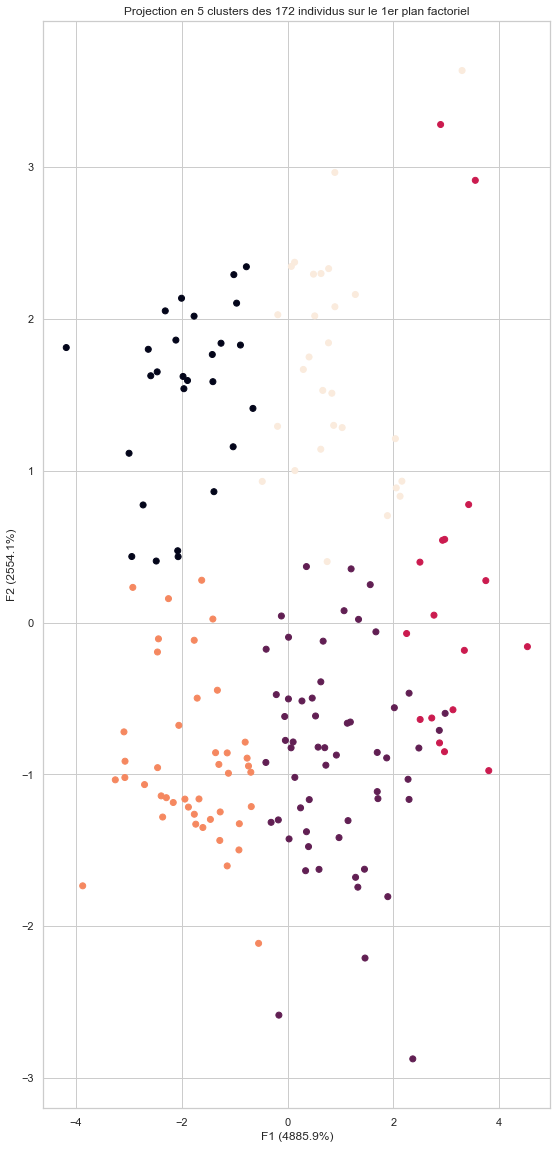

In [93]:
#pca = decomposition.PCA().fit(X_scaled) #sklearn
#X_projected = pca.transform(X_scaled)


#Coordonnées factorielles 
plt.figure(figsize=(20,20))
plt.subplot(122)
plt.scatter(X_projected[:, 0], X_projected[:, 1], c=km.labels_)
plt.xlabel('F{} ({}%)'.format(1, round(100*scree[0],1)))
plt.ylabel('F{} ({}%)'.format(2, round(100*scree[1],1)))
plt.title("Projection en 5 clusters des {} individus sur le 1er plan factoriel".format(X_projected.shape[0]))

plt.savefig("exports/projection_clusters.png")
plt.show()

L'analyse sera plus fine en 5 clusters. De plus, la comparaison sera possible avec les 5 groupes identifiés lors du précédent partitionnement, le contexte nous oriente davantage vers un clustering en 5 partitions.

Maintenant, il est nécessaire de caractériser chacun de ces groupes selon nos 8 variables. La position des centroïdes de chacun des groupes indiquera le ou les meilleurs clusters. C'est l'avantage de procéder en K-Means, afin d'obtenir directement des valeurs centrées et réduites, facilitant l'analyse. ⬇️

In [94]:
#correspondance avec les groupes de la CAH
pd.crosstab(groupe_cah,km.labels_)

col_0,0,1,2,3,4
row_0,,,,,
1,7,0,0,27,0
2,20,0,0,0,19
3,0,4,17,0,2
4,0,18,0,0,7
5,0,35,0,16,0


In [95]:
df_groupes_cah['Clusterkm'] = clusters_km
gb = df_groupes_cah.groupby('Clusterkm')
nk = gb.size()
print(nk)


Clusterkm
0    27
1    57
2    17
3    43
4    28
dtype: int64


In [96]:


# Moyennes conditionnelles
mk = gb.mean()
mk

,Évolution population (%),dispo_calories,dispo_proteines,ratio_proteines_animales(%),PIB_par_habitant,taux_suffisance(٪),taux_dépendance_importations(٪),groupe_cah
Clusterkm,,,,,,,,
0,21.261852,8.961156e+05,21891.753704,31.355185,2775.389067,23.741124,88.583142,1.740741
1,5.280000,1.146996e+06,33500.596491,47.905965,12596.803081,102.621295,17.846926,4.543860
2,9.161765,1.284757e+06,40857.670588,61.890588,63042.315906,92.916905,49.590605,3.000000
3,19.635581,9.097837e+05,23345.060465,26.194419,2135.812157,94.702523,9.058838,2.488372
4,5.708214,1.093722e+06,32640.516071,56.101429,16698.691096,24.210179,94.721700,2.571429


In [97]:
# Ajout des variables synthétiques F1 et F2
df_boxkm = pd.merge(df_groupes_cah, df_facto, on="pays", how="left")
df_boxkm = df_boxkm.sort_values("Clusterkm")
df_boxkm.head()

,pays,Évolution population (%),dispo_calories,dispo_proteines,ratio_proteines_animales(%),PIB_par_habitant,taux_suffisance(٪),taux_dépendance_importations(٪),groupe_cah,Clusterkm,F1,F2
68,Iraq,26.30,954475.0,23641.05,19.27,5729.677358,49.029126,52.427184,1,0,-2.069633,0.434334
96,Mauritanie,25.02,1049375.0,30265.80,37.69,1677.917728,16.666667,103.333333,2,0,-0.891837,1.827842
52,Ghana,20.54,1136610.0,22542.40,23.66,2202.629207,30.136986,69.863014,2,0,-1.392786,0.862234
131,Sao Tomé-et-Principe,18.22,876730.0,19914.40,32.53,1961.245810,33.333333,100.000000,2,0,-1.960511,1.540362
57,Guinée,21.98,1039885.0,20983.85,20.61,967.360684,31.428571,114.285714,2,0,-1.892117,1.594341


In [98]:
def boxplot_cluster_km(var):
    data_boxplot = []
    groupes_pays = df_boxkm["Clusterkm"].unique()
    
    for groupe in groupes_pays :
        subset = df_boxkm[df_boxkm.Clusterkm == groupe]
        data_boxplot.append(subset[var])

    fig, ax1 = plt.subplots(figsize=(12, 8))
    fig.subplots_adjust(left=0.075, right=0.95, top=0.9, bottom=0.25)

    bp = ax1.boxplot(data_boxplot, notch=0, vert=1, whis=1.5, labels=["0", "1", "2", "3", "4"])

    ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
               alpha=0.4)
    ax1.set_axisbelow(True)
    ax1.set_title(("Distribution de " + var +" par Cluster Kmeans"), fontsize=22)
    ax1.set_ylabel(var)
    ax1.set_xlabel("Cluster")
    ax1.set_xlim(0, len(data_boxplot) + 0.5)

    plt.show()

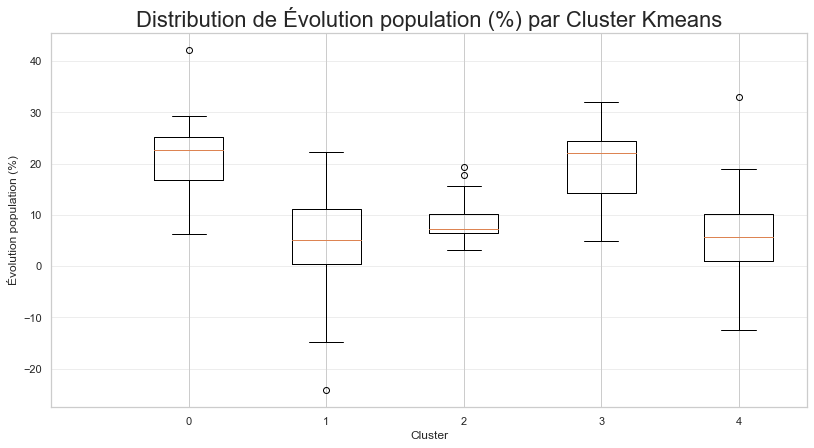

In [99]:
boxplot_cluster_km('Évolution population (%)')

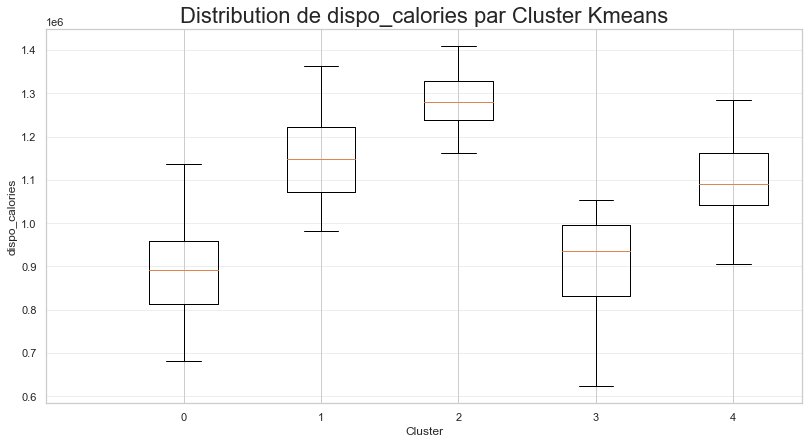

In [100]:
boxplot_cluster_km('dispo_calories')



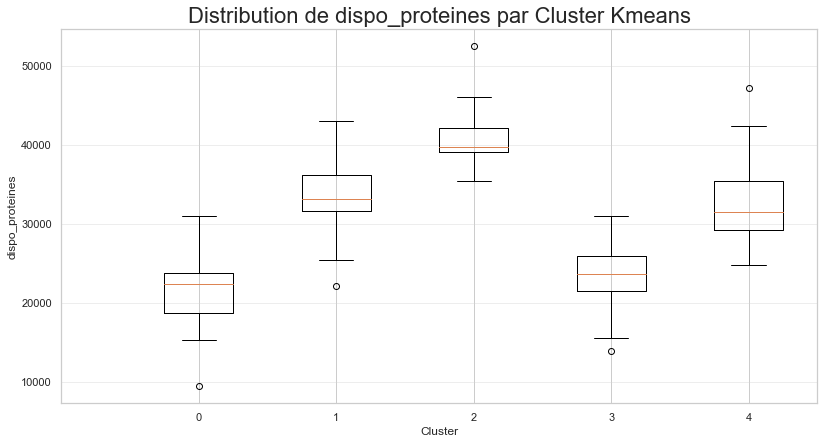

In [101]:
boxplot_cluster_km('dispo_proteines')


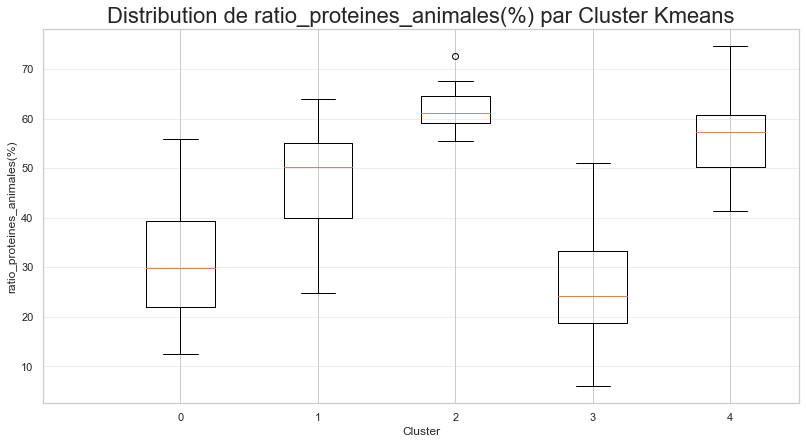

In [102]:
boxplot_cluster_km('ratio_proteines_animales(%)')


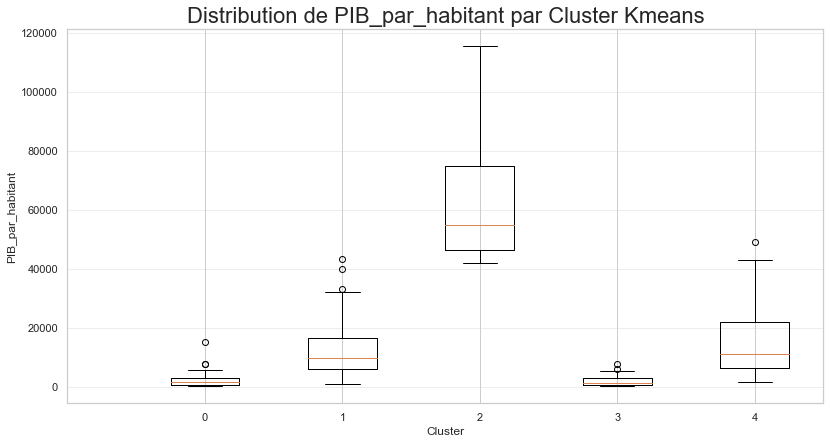

In [103]:
boxplot_cluster_km('PIB_par_habitant')


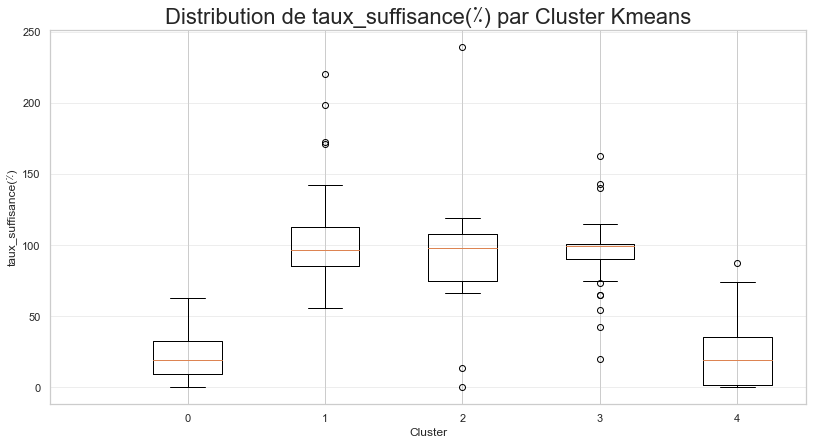

In [104]:
boxplot_cluster_km('taux_suffisance(٪)')


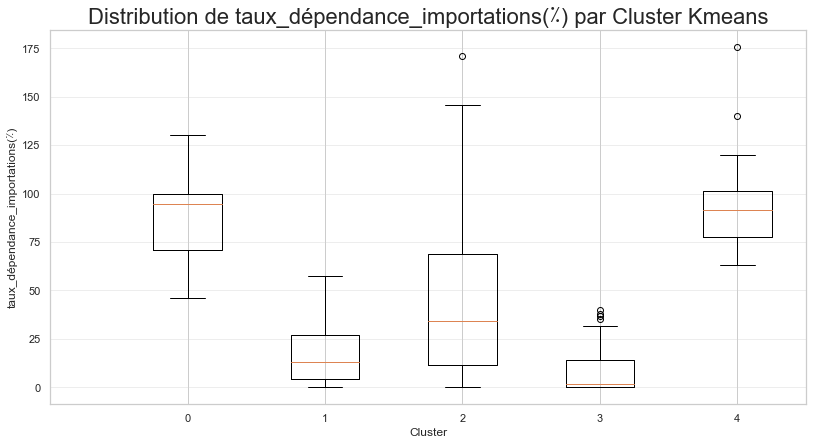

In [105]:
boxplot_cluster_km('taux_dépendance_importations(٪)')


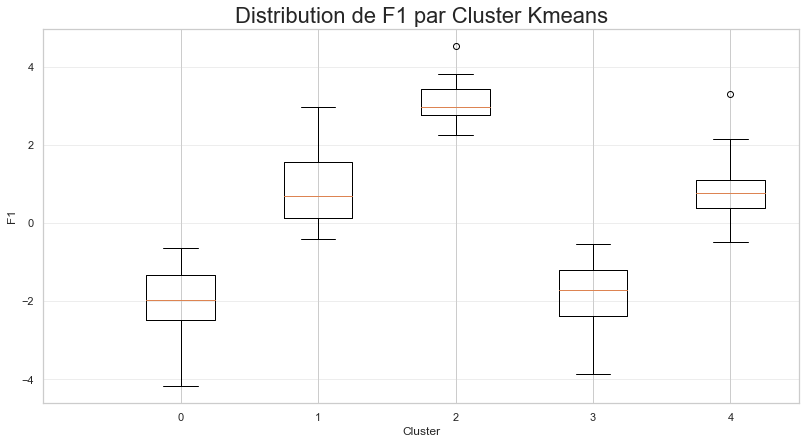

In [106]:
boxplot_cluster_km('F1')


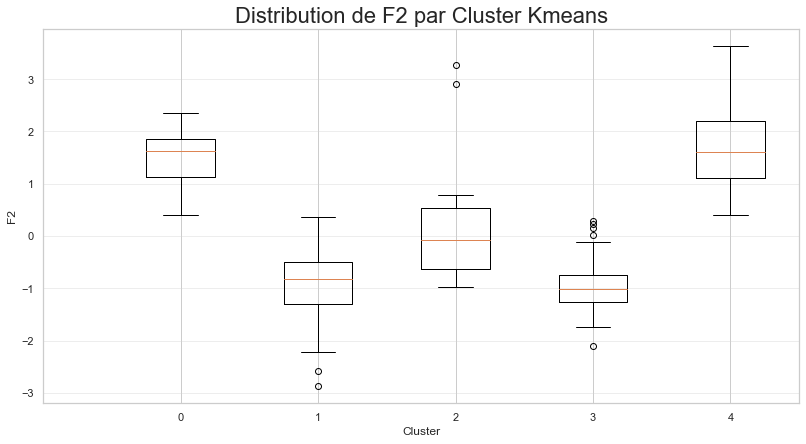

In [107]:
boxplot_cluster_km('F2')


# Sélections des pays sur groupes Kmeans.


In [108]:
select_clusters_kmeans = df_boxkm.groupby("Clusterkm").mean().reset_index()
select_clusters_kmeans = df_boxkm[df_boxkm["F2"]>1]["Clusterkm"].unique()
select_clusters_kmeans

array([0, 2, 4], dtype=int32)

In [109]:
df_select_pays_kmeans = df_boxkm[df_boxkm["Clusterkm"].isin(select_clusters_kmeans)]
df_select_pays_kmeans

,pays,Évolution population (%),dispo_calories,dispo_proteines,ratio_proteines_animales(%),PIB_par_habitant,taux_suffisance(٪),taux_dépendance_importations(٪),groupe_cah,Clusterkm,F1,F2
68,Iraq,26.30,954475.0,23641.05,19.27,5729.677358,49.029126,52.427184,1,0,-2.069633,0.434334
96,Mauritanie,25.02,1049375.0,30265.80,37.69,1677.917728,16.666667,103.333333,2,0,-0.891837,1.827842
52,Ghana,20.54,1136610.0,22542.40,23.66,2202.629207,30.136986,69.863014,2,0,-1.392786,0.862234
131,Sao Tomé-et-Principe,18.22,876730.0,19914.40,32.53,1961.245810,33.333333,100.000000,2,0,-1.960511,1.540362
57,Guinée,21.98,1039885.0,20983.85,20.61,967.360684,31.428571,114.285714,2,0,-1.892117,1.594341
...,...,...,...,...,...,...,...,...,...,...,...,...
129,Sainte-Lucie,5.78,961045.0,30769.50,58.20,11611.422134,16.666667,83.333333,2,4,0.296498,1.667130
130,Saint-Vincent-et-les Grenadines,2.08,1076385.0,33382.90,56.93,7463.537831,0.000000,88.888889,2,4,0.772292,1.842429
134,Seychelles,7.10,1139895.0,34967.00,52.90,17381.651083,25.000000,75.000000,2,4,1.030566,1.284307
61,Chine - RAS de Hong-Kong,6.88,1181140.0,47249.25,74.66,49180.094302,4.318182,175.681818,3,4,3.296647,3.635805


In [110]:
df_select_pays_kmeans.shape

(72, 12)

In [111]:
df_compare_1 = pd.merge(df_select_pays_cah[['pays','groupe_cah']], df_select_pays_kmeans[['pays','Clusterkm']],
                     on='pays', how='outer')
df_compare_1

,pays,groupe_cah,Clusterkm
0,Arménie,2.0,4.0
1,Angola,2.0,0.0
2,Antigua-et-Barbuda,2.0,4.0
3,Australie,3.0,2.0
4,Autriche,3.0,2.0
...,...,...,...
71,Bulgarie,NaN,4.0
72,Estonie,NaN,4.0
73,Géorgie,NaN,4.0
74,Lettonie,NaN,4.0


In [112]:
df_select_pays_km_cah=df_compare_1.dropna()
df_select_pays_km_cah



,pays,groupe_cah,Clusterkm
0,Arménie,2.0,4.0
1,Angola,2.0,0.0
2,Antigua-et-Barbuda,2.0,4.0
3,Australie,3.0,2.0
4,Autriche,3.0,2.0
5,Bahamas,2.0,4.0
6,Botswana,2.0,0.0
7,Îles Salomon,2.0,0.0
8,Canada,3.0,2.0
9,Cabo Verde,2.0,0.0


Liste des pays et recommandations
Dans un premier temps, on suggère donc de cibler les pays de l'UE, pour leur proximité et la facilité des échanges commerciaux : l'Allemagne,  les Pays-Bas, la Suède ,Luxembourg et l'Italie.

Prudence avec le Royaume-Uni, puisqu'avec le Brexit, les échanges commerciaux avec l'UE sont actuellement compliqués. Pour autant, considérant les intérêts économiques mutuels, les récentes directives qui ont été prises pour favoriser ces échanges sont en notre faveur.

Dans un second temps, on pourrait également cibler les pays comme Hong Kong, le Japon, , ainsi que le Koweït.

FAO - Poultry production - Marchés et commerce
https://www.fao.org/poultry-production-products/aspects-socio-economiques/marches-et-commerce/fr/

"Le Brésil est le principal exportateur de viande de volaille, suivi par les États-Unis et les Pays-Bas. Les principaux pays importateurs sont la Chine, le Japon, le Mexique et le Royaume-Uni."

"Les pays les moins avancés sont de plus en plus dépendants des importations de viande de volaille. Le niveau de leurs importations est passé de 3 pour cent en 1961 à environ 30 pour cent en 2013."

FAO - Poultry production

https://www.fao.org/poultry-production-products/production/fr/

"Les États-Unis d'Amérique sont le plus grand producteur de viande de volaille à l’échelle de la planète: ils produisent en effet 17 pour cent de la production mondiale. Viennent ensuite la Chine et le Brésil."

"Pour répondre à la demande croissante, la production de viande de volaille mondiale a bondi, passant de 9 à 132 millions de tonnes entre 1961 et 2019."

"En 2019, la viande de volaille représentait environ 39 pour cent de la production mondiale de viande."

"Dans les pays en développement, environ 80 pour cent des ménages ruraux élèvent des volailles."

# Tests statistiques
## Nos groupes sont-ils réellement distincts?
### Test d'adéquation de Kolmogorov-Smirnov :
On peut tester l’adéquation de la 'Disponibilité alimentaire de prot (g/personne/jour)' à une loi normale à l’aide de Kolmogorov-Smirnov. Le test sera doublé par celui de Shapiro-Wilk.

In [80]:
import scipy.stats as st
from scipy import stats
from scipy.stats import ks_2samp

### Vérification des hypothèses

**H0 = La variable suit donc  une loi normale .**

**H1 = La variable ne suit pas une loi normale.**

In [81]:
df_groupes_cah.head(1)

,pays,Évolution population (%),dispo_calories,dispo_proteines,ratio_proteines_animales(%),PIB_par_habitant,taux_suffisance(٪),taux_dépendance_importations(٪),groupe_cah,Clusterkm
0,Arménie,2.35,1103030.0,34415.85,56.06,4622.733216,21.818182,78.181818,2,4


In [82]:
#Kolmogorov Smirnov test
stat, p= st.ks_2samp(df_groupes_cah['dispo_proteines'], 
            np.random.normal(df_groupes_cah['dispo_proteines'].mean(), 
                             df_groupes_cah['dispo_proteines'].std(ddof=0),
                             df_groupes_cah['dispo_proteines'].count()))

print('Statistics=%.3f, p=%.3f' % (stat, p))

#Interprétation
alpha = 0.05
if p > alpha:
    print(' Nous pouvons accepter H0 pour des niveaux de test de 5 %')
else:
    print('H0 est rejetée à un niveau de test de 5%')
    

Statistics=0.105, p=0.304
 Nous pouvons accepter H0 pour des niveaux de test de 5 %


### Test d'adéquation de Shapiro-Wilk :

*Recommandé pour tester la normalité dans le cas de petits échantillons.

In [83]:
#creation of the df with only clusters 4 & 5
c4c5 = df_groupes_cah[(df_groupes_cah['groupe_cah'] == 3) | (df_groupes_cah['groupe_cah'] == 5)]

In [84]:
#conda install -c conda-forge pingouin
#Pingouin is an open-source statistical package written in Python 3 and based mostly on Pandas and NumPy. 

In [85]:
#normality of variables in c4c5
import pingouin as pg
pg.normality(c4c5, method='shapiro', alpha=0.05).drop('groupe_cah')



,W,pval,normal
Évolution population (%),0.991761,9.165989e-01,True
dispo_calories,0.973411,1.203359e-01,True
dispo_proteines,0.969186,6.745765e-02,True
ratio_proteines_animales(%),0.974942,1.482540e-01,True
PIB_par_habitant,0.756683,9.696263e-10,False
taux_suffisance(٪),0.865643,1.255049e-06,False
taux_dépendance_importations(٪),0.627375,2.066064e-12,False
Clusterkm,0.763252,1.398323e-09,False


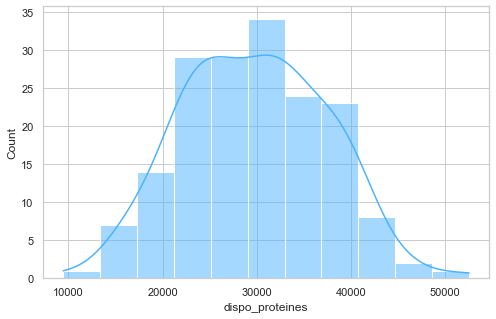

In [86]:
#histogram
sns.histplot(data=df_groupes_cah, x='dispo_proteines', kde=True, color='#4cb2ff')
plt.show()

#### Disponibilité alimentaire énergétique


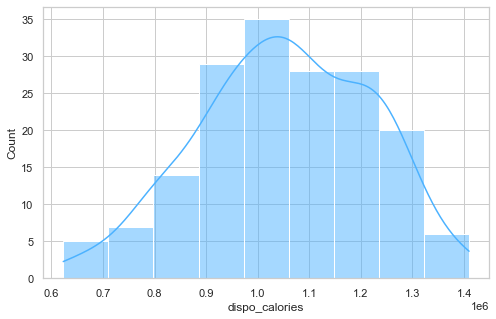

In [87]:
#histogram
sns.histplot(data=df_groupes_cah, x='dispo_calories', kde=True, color='#4cb2ff')
plt.show()

#### Importation de viande de volaille


In [88]:
#histogram
sns.histplot(data=df_groupes_cah, x='Evolution population (%)', kde=True, color='#4cb2ff')
plt.show()

ValueError: Could not interpret value `Evolution population (%)` for parameter `x`

#### Pourcentage de protéine animale


In [ ]:
#histogram
sns.histplot(data=df_groupes_cah, x='ratio_proteines_animales', kde=True, color='#4cb2ff')
plt.show()

#### Produit Intérieur Brut


In [ ]:
#histogram
sns.histplot(data=df_groupes_cah, x='PIB par habitant', kde=True, color='#4cb2ff')
plt.show()

#### Importation de viande de volaille


In [ ]:
#histogram
sns.histplot(data=df_groupes_cah, x='Production', kde=True, color='#4cb2ff')
plt.show()


In [ ]:
#histogram
sns.histplot(data=df_groupes_cah, x='taux_suffisance(٪)', kde=True, color='#4cb2ff')
plt.show()

### Test de comparaison de deux clusters dans le cas gaussien.



#### La variable 'dispo_proteines' suit une loi normale et sera par conséquent choisie pour le test.

In [ ]:
#On teste tout d’abord l’égalité des variances à l’aide de la commande
pg.homoscedasticity(c4c5, dv='dispo_proteines', 
                    group='groupe_cah', method='levene', 
                    alpha=0.05)

In [ ]:
#On teste ensuite l’égalité des moyennes à l’aide de la commande
pg.ttest(df_groupes_cah['dispo_proteines'][df_groupes_cah['groupe_cah'] == 3],
         df_groupes_cah['dispo_proteines'][df_groupes_cah['groupe_cah'] == 5],
         paired=False,
        
         confidence=0.95)

### Conclusion

In [ ]:
α = 0.05

if α > pg.ttest(df_groupes_cah['dispo_proteines'][df_groupes_cah['groupe_cah'] == 3],
             df_groupes_cah['dispo_proteines'][df_groupes_cah['groupe_cah'] == 5]).iloc[0,3] : 
    
    print("La p-value étant inférieure au risque α, on rejette donc H0, les moyennes des deux groupes sont différentes.")
else :
    print("La p-value étant supérieur au risque α, H0 est donc vrai, les moyennes des deux groupes sont égales.")